In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kimbbaro","key":"0eee4ddbd0a80636c2a3f8146af07993"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c porto-seguro-safe-driver-prediction

 88% 67.0M/76.5M [00:00<00:00, 102MB/s]
100% 76.5M/76.5M [00:00<00:00, 107MB/s]


In [4]:
!unzip /content/porto-seguro-safe-driver-prediction.zip

Archive:  /content/porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import Imputer

#누락된 값을 대체하기 위해 중앙값, 최빈값을 만드는? 그런 기능을 함.
from sklearn.impute import SimpleImputer
#다항식 특징 생성을 위한 모듈입니다. 주어진 특징을 최고 차수까지 제곱, 세제곱 등을 하여 새로운 특징을 생성합니다.
from sklearn.preprocessing import PolynomialFeatures
#데이터 스케일링을 위한 모듈입니다. 주어진 데이터의 평균을 0으로, 분산을 1로 만들어주는 작업을 수행합니다. 
from sklearn.preprocessing import StandardScaler
#분산이 너무 작은 특징을 제거하는 모듈입니다. 주어진 분산 임계값보다 작은 특징은 제거합니다. -> 왜 제거해야하지?
from sklearn.feature_selection import VarianceThreshold
#모델 기반 특징 선택을 위한 모듈, 지정한 모델을 학습하여 각 특징의 중요도를 파악하고, 중요도가 낮은 특징을 제거합니다.
from sklearn.feature_selection import SelectFromModel
#이터를 무작위로 섞어주는 함수입니다.
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", 100)

In [6]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [7]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [8]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


In [9]:
train.shape

(595212, 59)

In [10]:
train.drop_duplicates() #중복된 행을 제거하는거.
train.shape 

(595212, 59)

In [11]:
test.shape

(892816, 58)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [13]:
data = []
#이걸 왜 하는거지..
#
for f in train.columns:
  #role을 결정. role이 무엇을 의미하는지는 모르겠음.
  if f == "target":
    role = "target"
  elif f == "id":
    role = "id"
  else:
    role = "input"

  #level을 결정하자.
  if "bin" in f or f == "target":
    level = "binary"
  elif "cat" in f or f == "id":
    level = "nominal"
  elif train[f].dtype == float:
    level = "interval"
  elif train[f].dtype == int:
    level = 'ordinal'

  #id면 keep을 false로 바꾼다.
  keep = True
  if f=="id":
    keep = False

  dtype = train[f].dtype

  f_dict = {
      "varname" : f,
      "role" : role,
      "level" : level,
      "keep" : keep,
      "dtype" : dtype
  }

  data.append(f_dict)

#생성할 데이터프레임의 columns를 의미.
meta = pd.DataFrame(data, columns=["varname", "role", "level", "keep", "dtype"])
#varname을 인덱스로 사용하자.
meta.set_index("varname", inplace = True)

In [14]:
meta #그 데이터의 역할, 레벨, 킵, 데이터 타입을 보여주는걸 만든거다.

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [15]:
meta[(meta.level == "nominal") & (meta.keep)].index #아 이렇게 뽑아낼 수 있구나.

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [16]:
pd.DataFrame({"count" : meta.groupby(["role", "level"])["role"].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


In [17]:
v = meta[(meta.level =="interval") & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [18]:
v = meta[(meta.level=="ordinal") & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [19]:
v = meta[(meta.level=="binary") & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# "Undersampling": 다수 클래스(majority class) 샘플을 일부만 사용하여 소수 클래스(minority class) 샘플과 비슷한 수의 샘플을 갖도록 하는 방법입니다.
# "Oversampling": 소수 클래스(minority class) 샘플을 복제하여 다수 클래스(majority class) 샘플과 비슷한 수의 샘플을 갖도록 하는 방법입니다.

#undersampling : 많은 데이터 열을 줄이는거..

desired_apriori = 0.10

idx_0 = train[train.target==0].index
idx_1 = train[train.target==1].index

nb_0 = len(train.loc[idx_0]) #target == 0인 값들의 길이.
nb_1 = len(train.loc[idx_1]) #target == 1인 값들의 길이.

#0.9 * target==1의 길이 / 0.1 * target==0의 길이.
undersampling_rate = ((1-desired_apriori) * (nb_1)/(nb_0 * desired_apriori))
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

undersampled_idx = shuffle(idx_0, random_state = 37, n_samples=undersampled_nb_0)

#target==0이 많으니까 이를 줄이는거네.
#idx_list는 기존 target == 1과 줄인 idx를 더한거고.
idx_list = list(undersampled_idx) + list(idx_1)

train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [22]:
vars_with_missing = []

for f in train.columns:
  missings = train[train[f] == -1][f].count()
  if missings > 0:
    vars_with_missing.append(f)
    missings_perc = missings/train.shape[0]

    print("Variable {} has {} records ({:.2%}) with missing values".format(f, missings, missings_perc))
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


In [29]:
# vars_to_drop = ["ps_car_03_cat", "ps_car_05_cat"]
# train.drop(vars_to_drop, inplace = True, axis=1)
# meta.loc[(vars_to_drop), 'keep'] = False



mean_imp = SimpleImputer(missing_values = -1, strategy = "mean")
mode_inp = SimpleImputer(missing_values = -1, strategy = "most_frequency")
#ravel : ravel() 메서드는 반환된 값을 1차원 배열로 변환합니다. 
#fit_trains : mean_imp 객체에서 정의한 처리 방식(여기서는 평균 값으로 대체)을 훈련 데이터에 적용하여 대체된 값을 반환
train["ps_reg_03"] = mean_imp.fit_transform(train[["ps_reg_03"]]).ravel()
train["ps_car_12"] = mean_imp.fit_transform(train[["ps_car_12"]]).ravel()
train["ps_car_14"] = mean_imp.fit_transform(train[["ps_car_14"]]).ravel()
train["ps_car_11"] = mean_imp.fit_transform(train[["ps_car_11"]]).ravel()

In [30]:
v = meta[(meta.level == "nominal") & (meta.keep)].index

for f in v:
  dist_values = train[f].value_counts().shape[0]
  print("variables {} has {} distinct values". format(f,dist_values))

variables ps_ind_02_cat has 5 distinct values
variables ps_ind_04_cat has 3 distinct values
variables ps_ind_05_cat has 8 distinct values
variables ps_car_01_cat has 13 distinct values
variables ps_car_02_cat has 3 distinct values
variables ps_car_04_cat has 10 distinct values
variables ps_car_06_cat has 18 distinct values
variables ps_car_07_cat has 3 distinct values
variables ps_car_08_cat has 2 distinct values
variables ps_car_09_cat has 6 distinct values
variables ps_car_10_cat has 3 distinct values
variables ps_car_11_cat has 104 distinct values


이해가 안돼...


In [35]:
# def add_nosie(series, noise_level):
#   return series * (1+noise_level * np.random.randn(len(series)))

# def target_encode(trn_series = None, #뭐지 이거...?
#               tst_series = None,
#               target = None,
#               min_samples_leaf = 1,
#               smoothing = 1,
#               noise_level = 0):
#   #assert문은 주어진 조건이 True인지 확인하고, 조건이 False인 경우 AssertionError를 발생시킵니다.
#   #디버깅용
#   assert len(trn_series) == len(target)
#   assert trn_series.name == tst_series.name
#   temp = pd.concat([trn_series, target], axis = 1)
#   #trn_series 열의 값에 따라 그룹핑하는 작업을 수행합니다.
#   #agg(["mean", "count"])는 각 그룹별로 target 열의 평균과 데이터 수(count)를 계산합니다. 이 때 agg() 메서드는 문자열 리스트 ["mean", "count"]를 전달하여 평균과 데이터 수를 계산하도록 지정하고, 계산 결과는 DataFrame으로 반환합니다.

#   averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
#   smoothing = 1/(1+np.exp(-(averages["count"] - min_samples_leaf)/ smoothing))
#   prior = target.mean()

#   averages[target.name] = prior * (1-smoothing) + averages["mean"] + smoothing
#   averages.drop(["mean", "count"], axis = 1, inplace = True)

#   ft_trn_series = pd.merge(
#       trn_series.to_frame(trn_series.name),
#       averages.reset_index().rename(columns = {"index" : target.name, target.name:"average"}),
#       on = trn_series.name,
#       how = 'left')["average"].rename(trn_series.name + "_mean").fillna(prior)

#   ft_trn_series.index = trn_series.index
#   ft_tst_series = pd.merge(
#       tst_series.to_frame(tst_series.name),
#       averages.reset_index().rename(columns = {"index" : target.name, target.name:"average"}),
#       on = tst_series.name,
#       how = 'left')["average"].rename(trn_series.name + "_mean").fillna(prior)

#   ft_tst_series.index = tst_series.index
#   return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [37]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [38]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"],
                                            test["ps_car_11_cat"],
                                            target = train.target,
                                            min_samples_leaf = 100,
                                            smoothing = 10,
                                            noise_level = 0.01)

<Figure size 640x480 with 0 Axes>

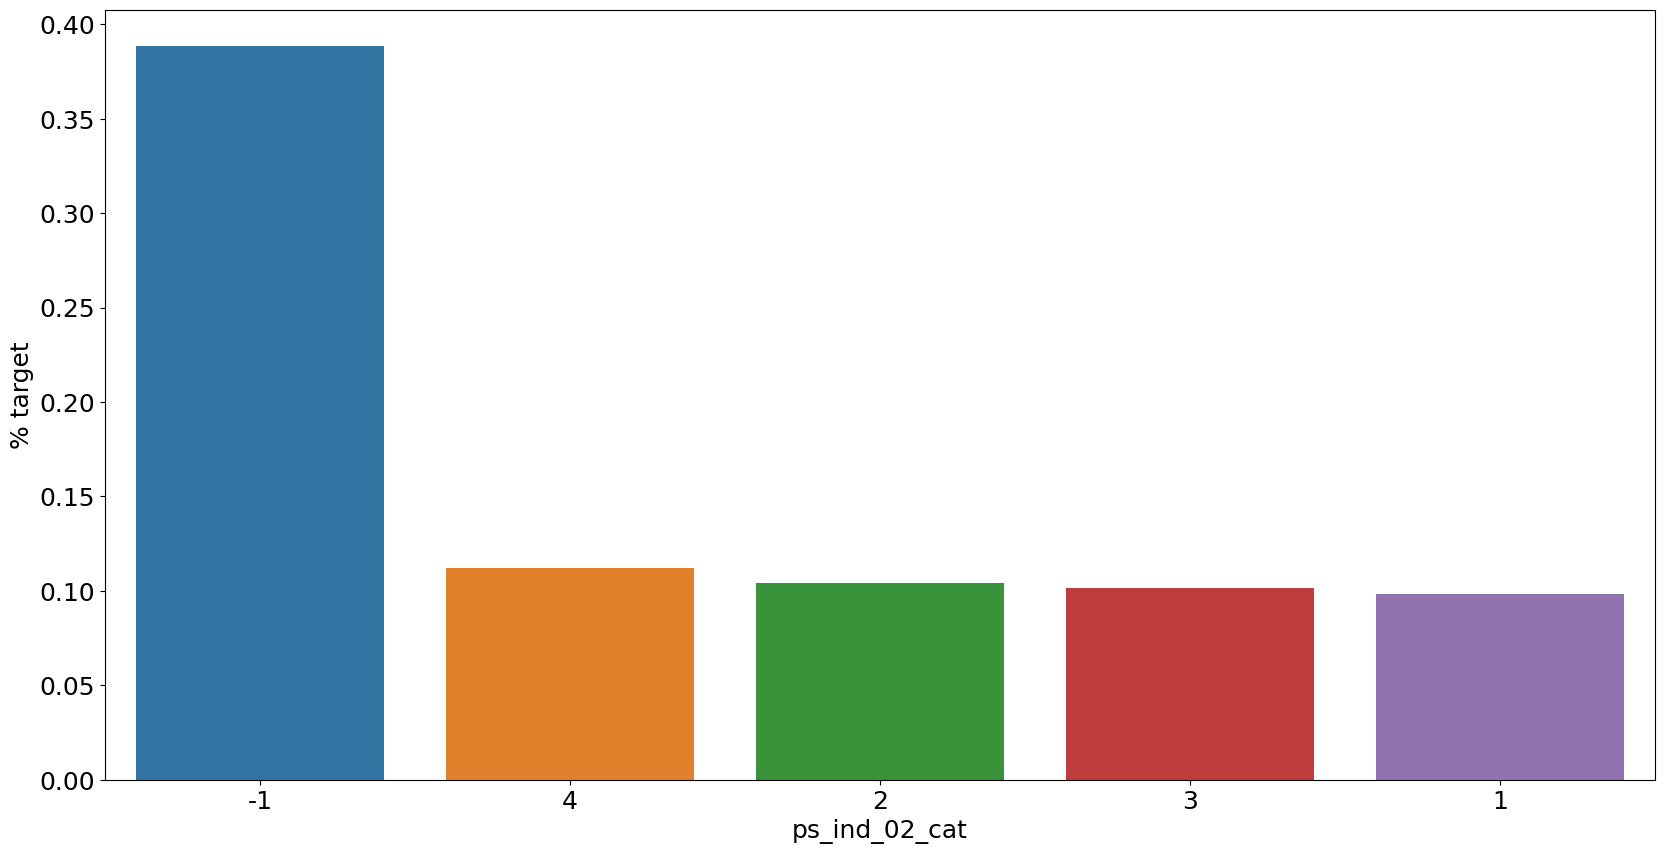

<Figure size 640x480 with 0 Axes>

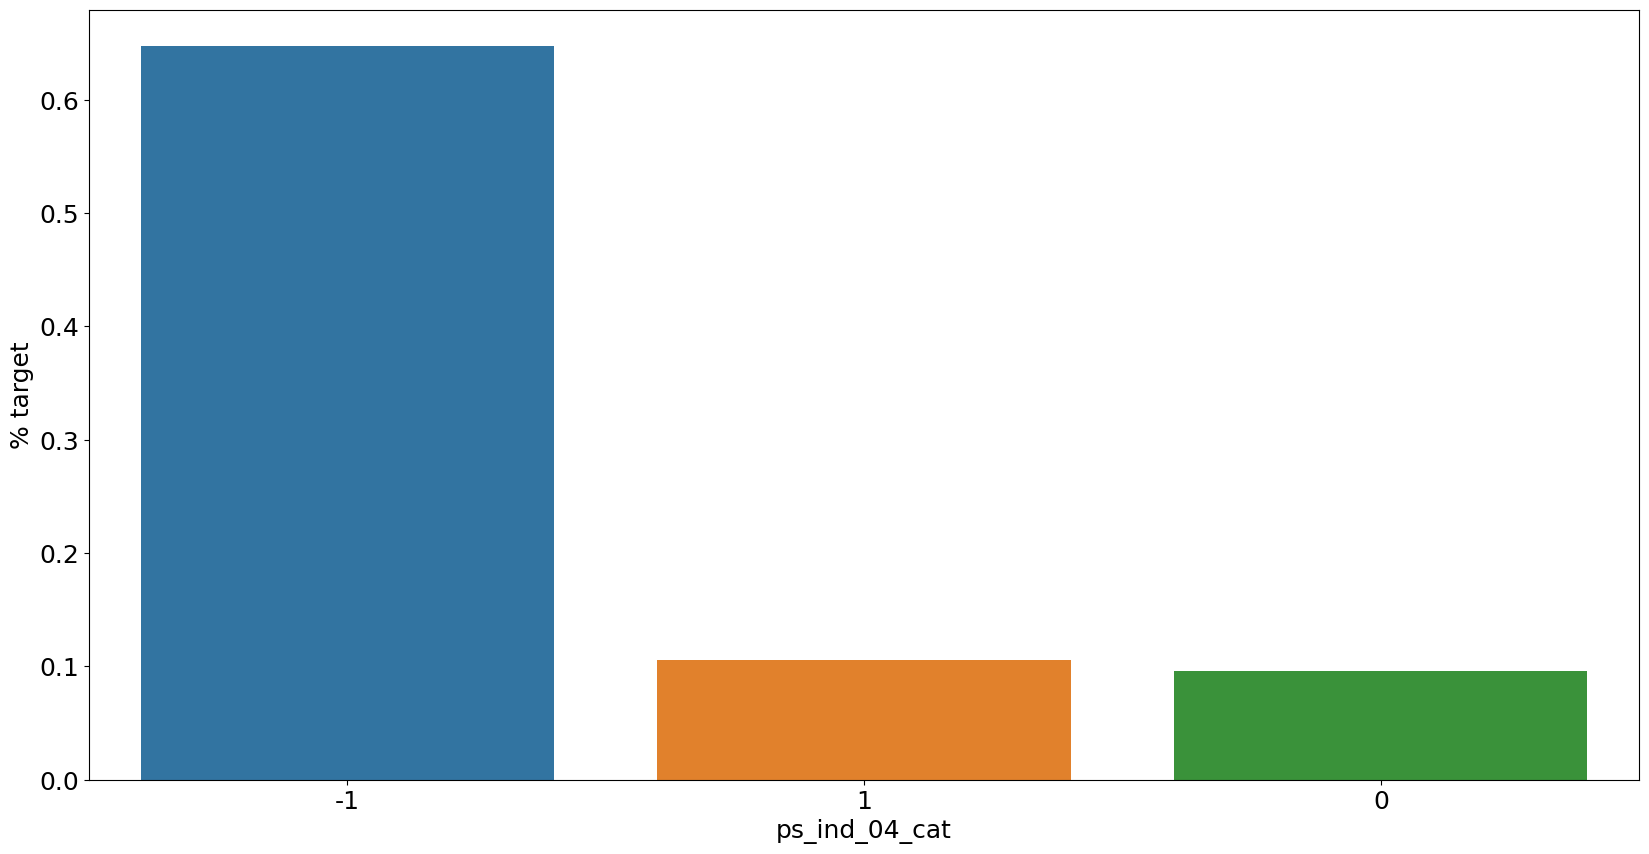

<Figure size 640x480 with 0 Axes>

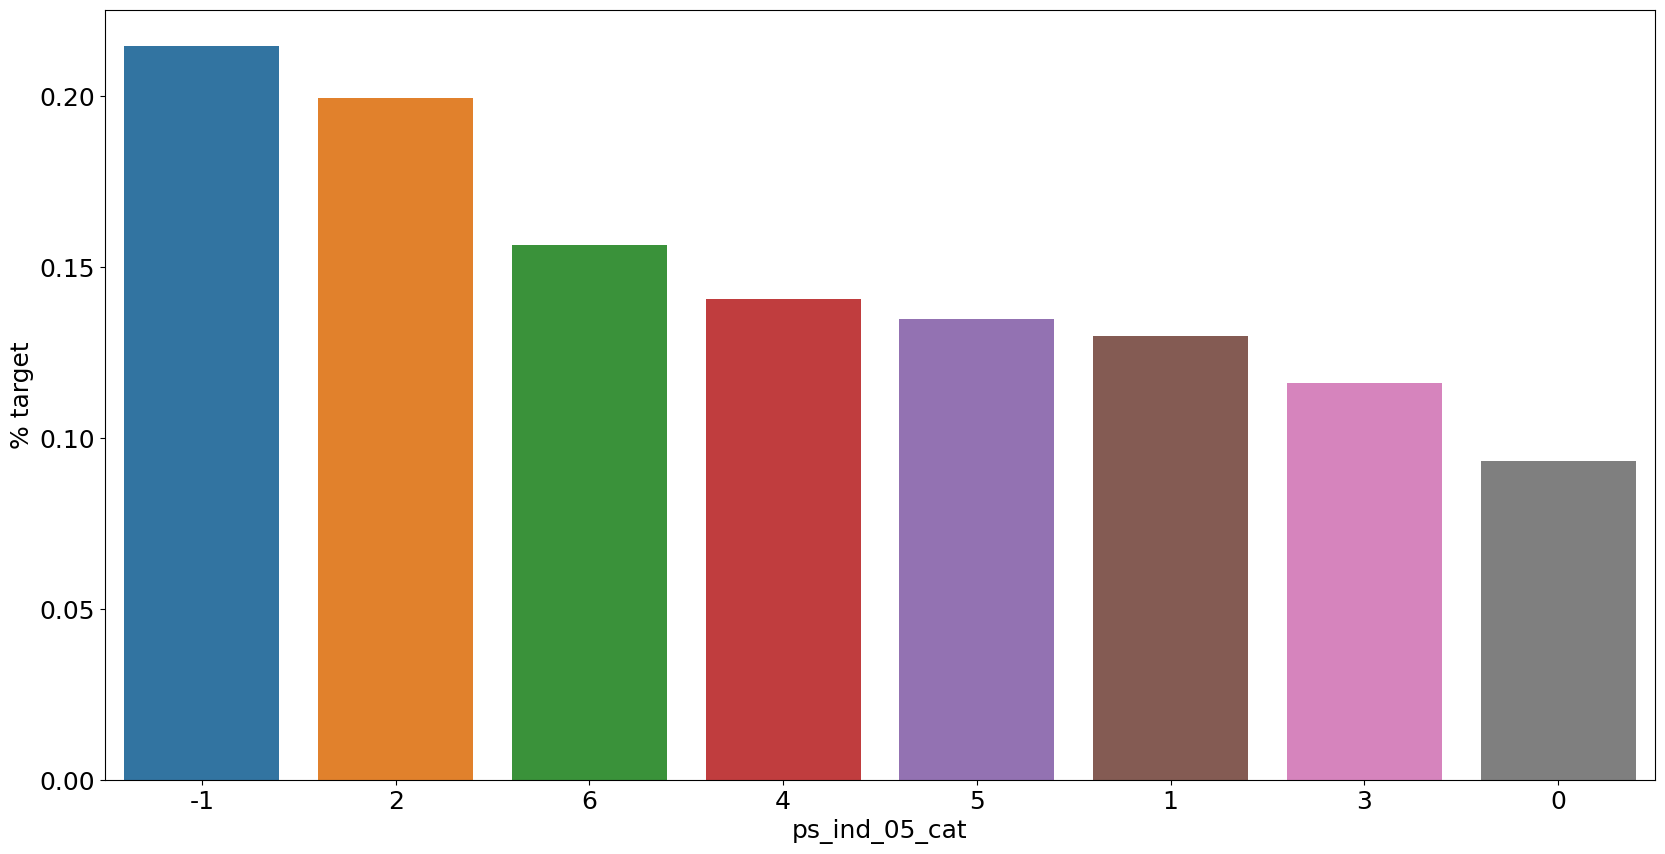

<Figure size 640x480 with 0 Axes>

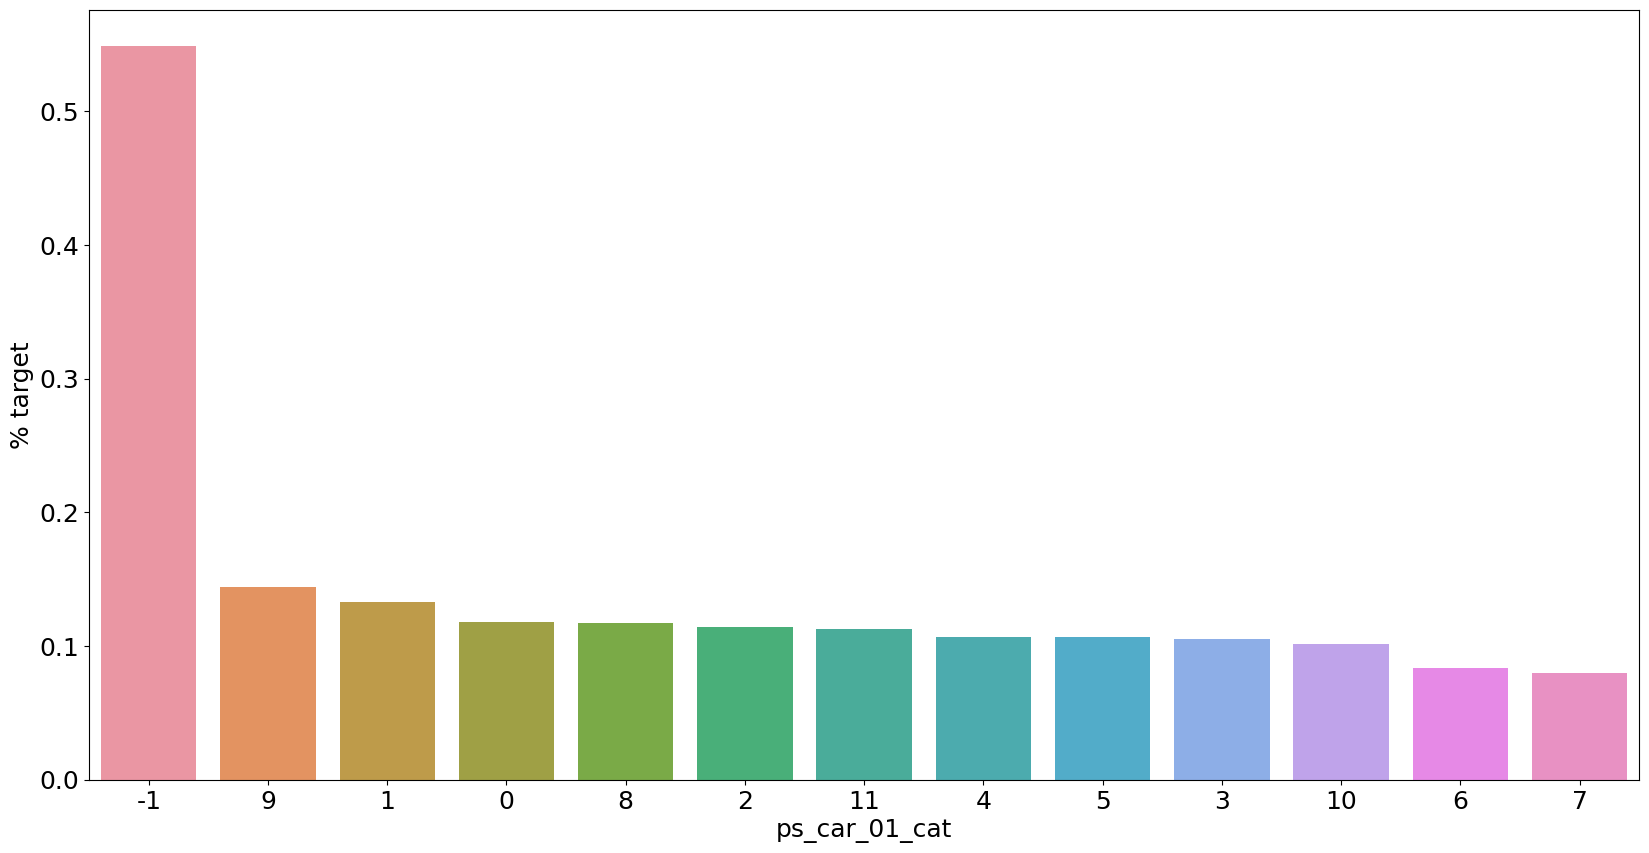

<Figure size 640x480 with 0 Axes>

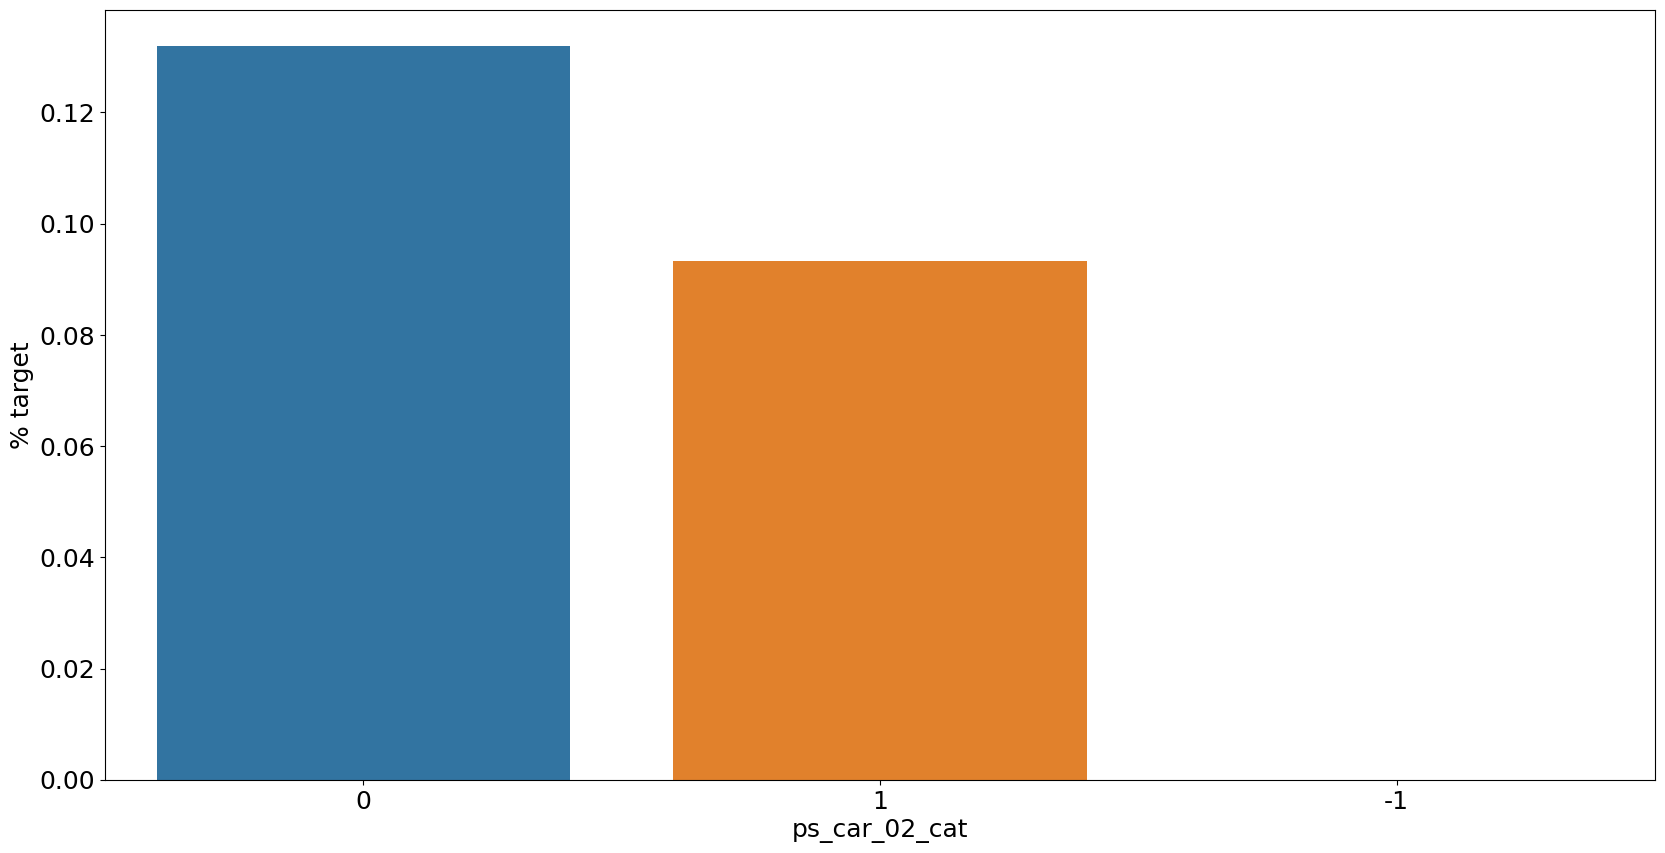

<Figure size 640x480 with 0 Axes>

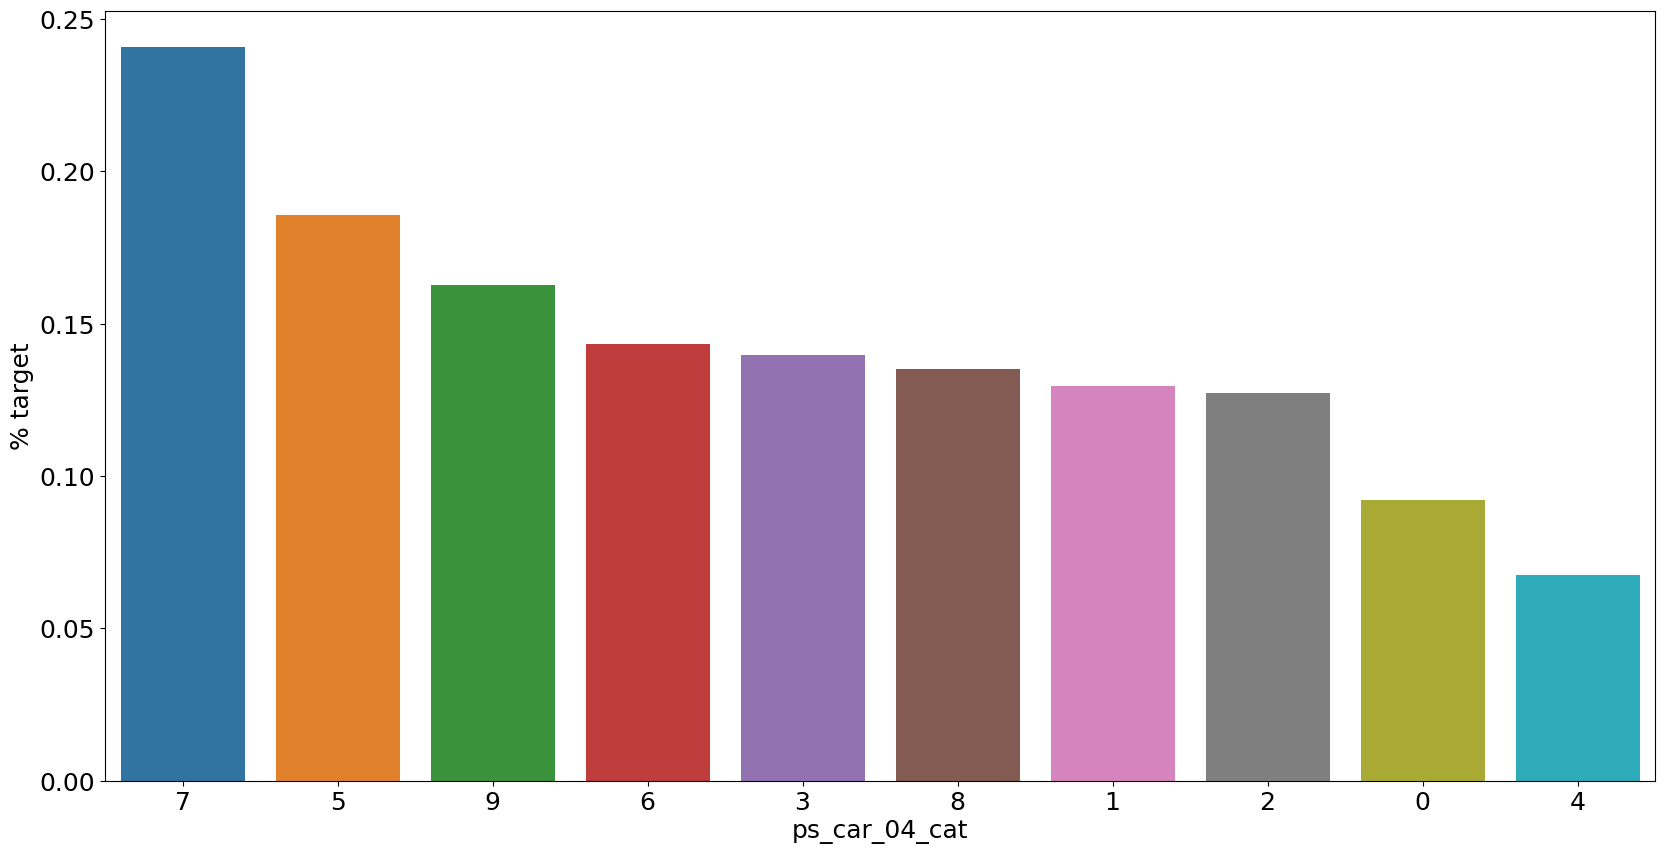

<Figure size 640x480 with 0 Axes>

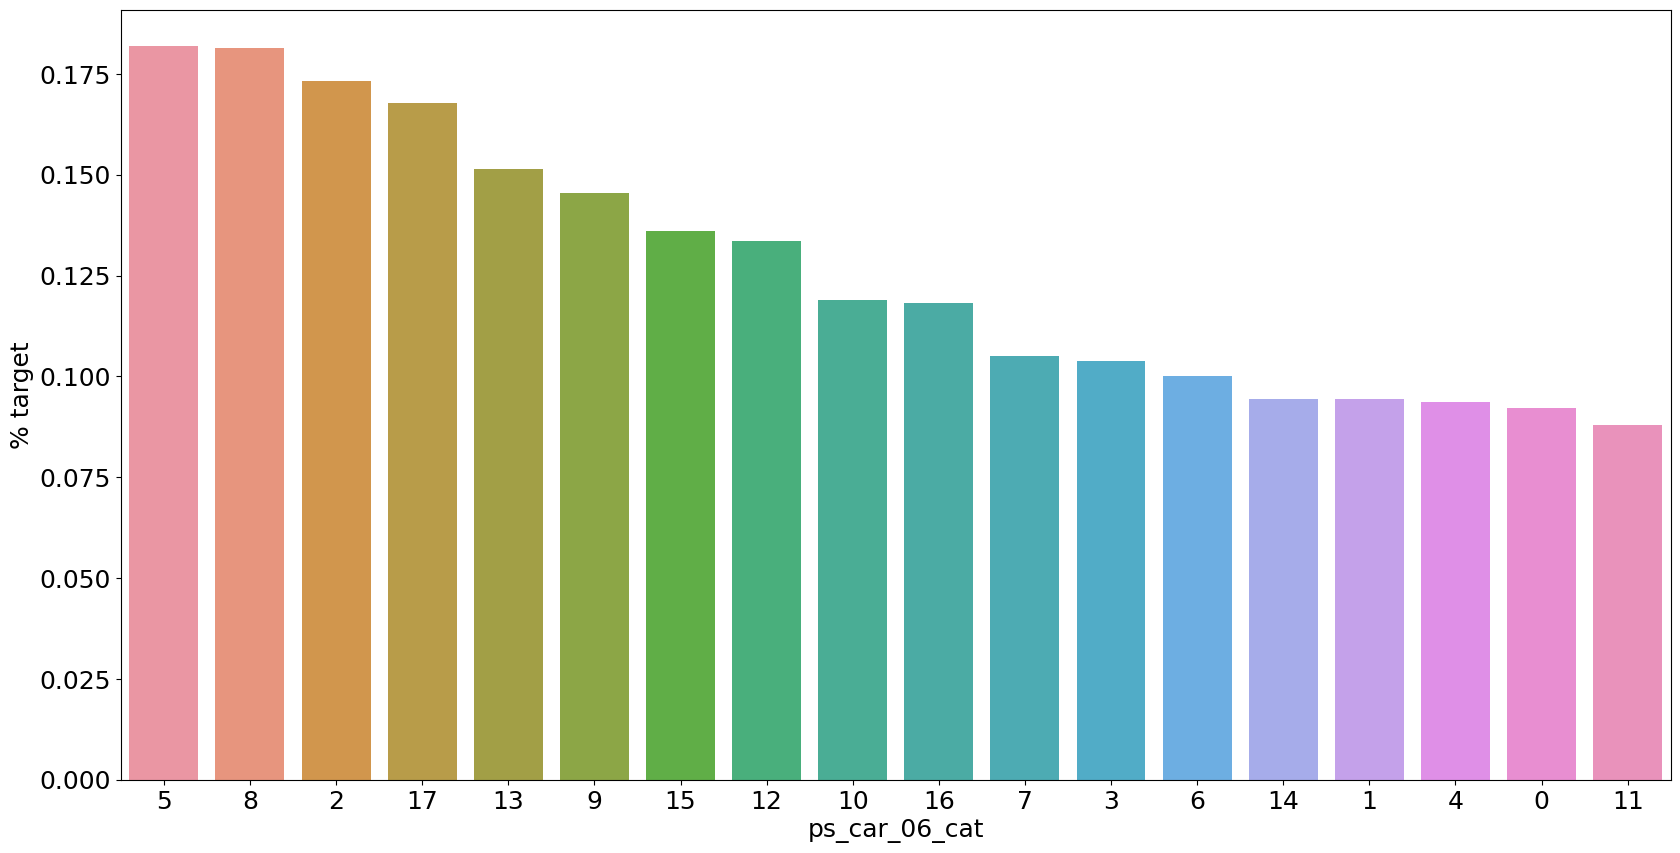

<Figure size 640x480 with 0 Axes>

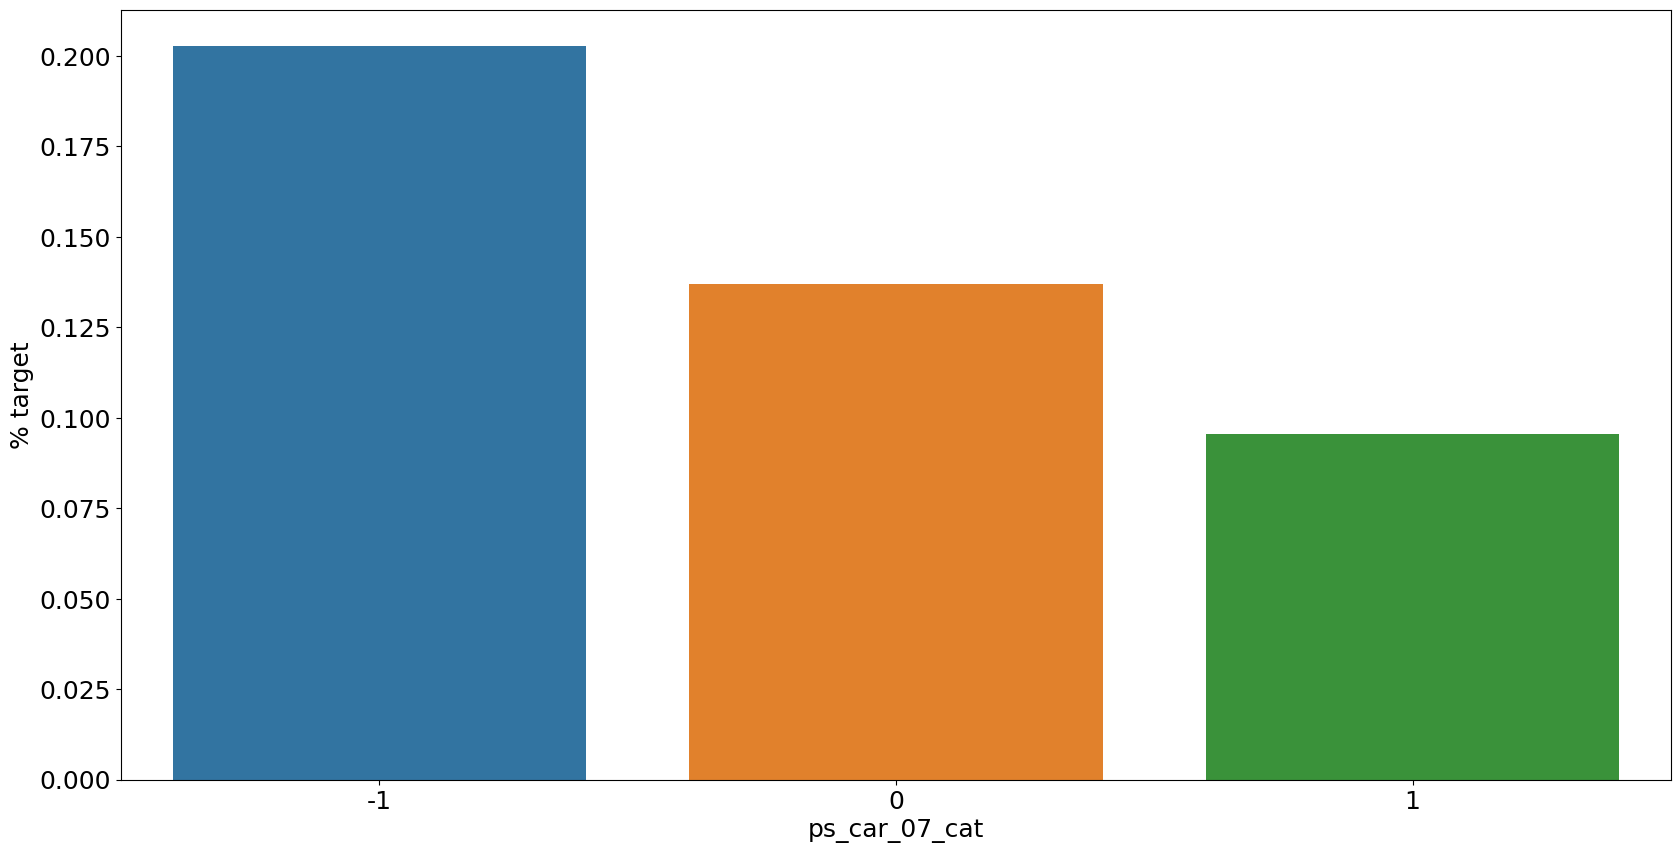

<Figure size 640x480 with 0 Axes>

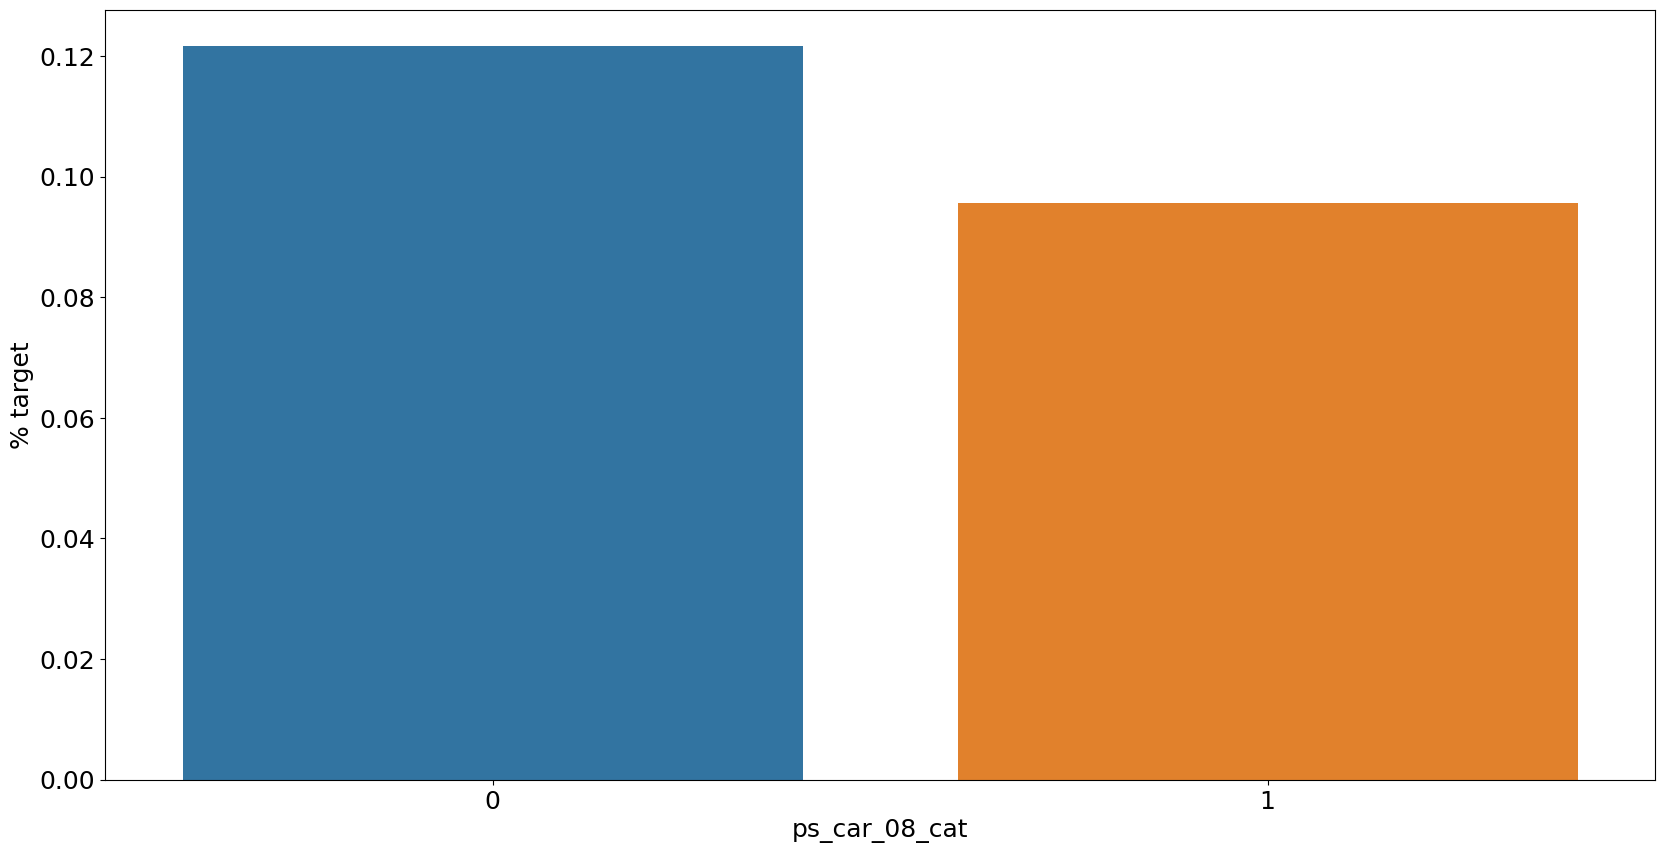

<Figure size 640x480 with 0 Axes>

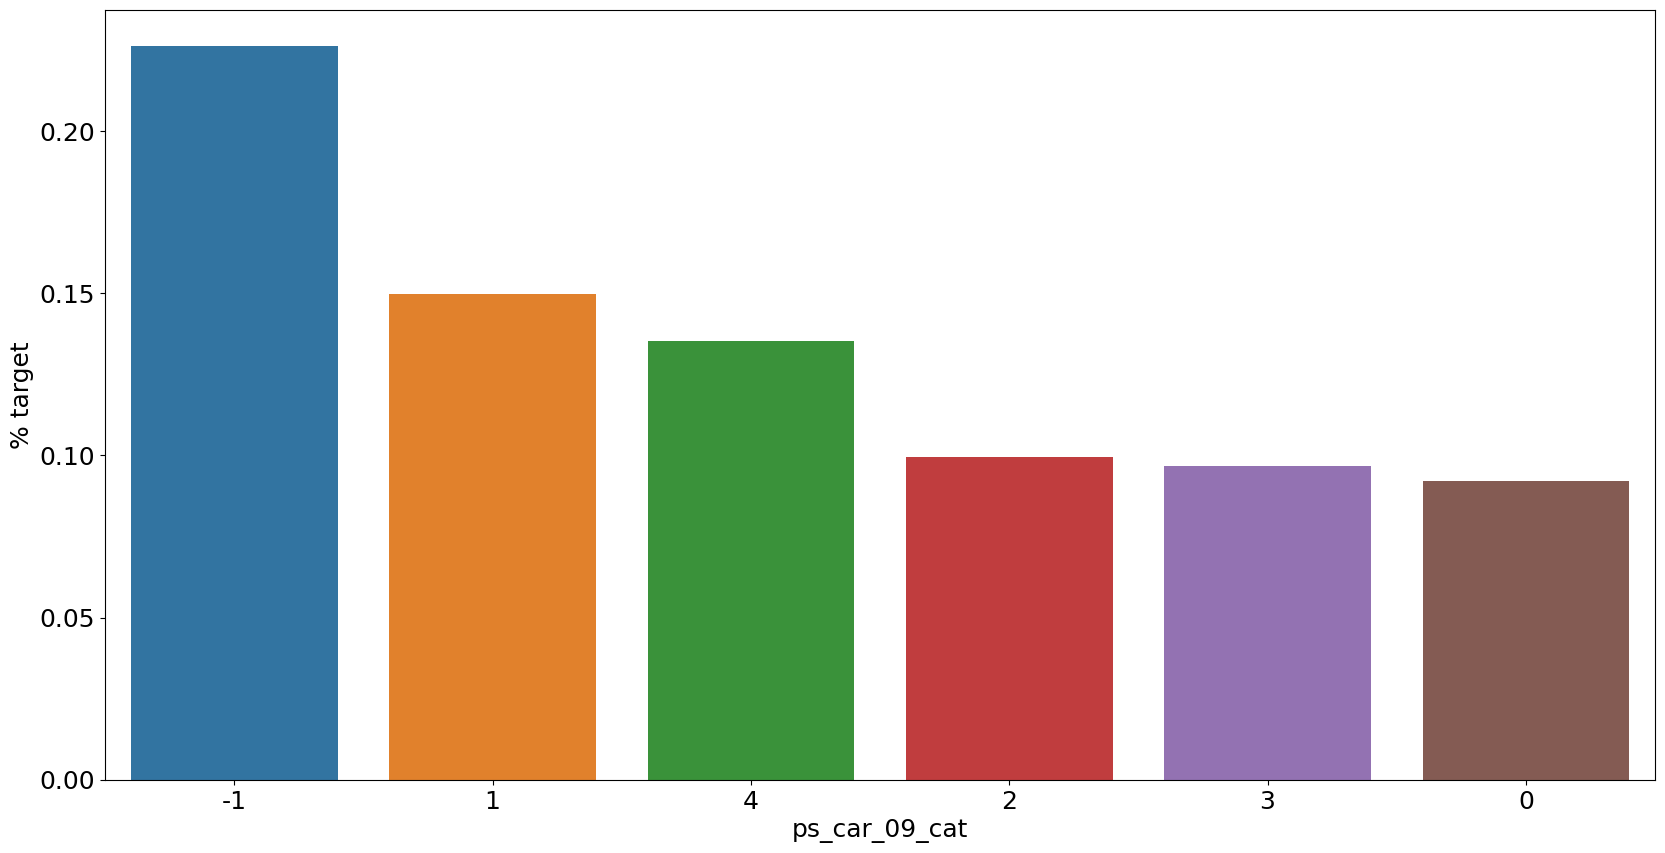

<Figure size 640x480 with 0 Axes>

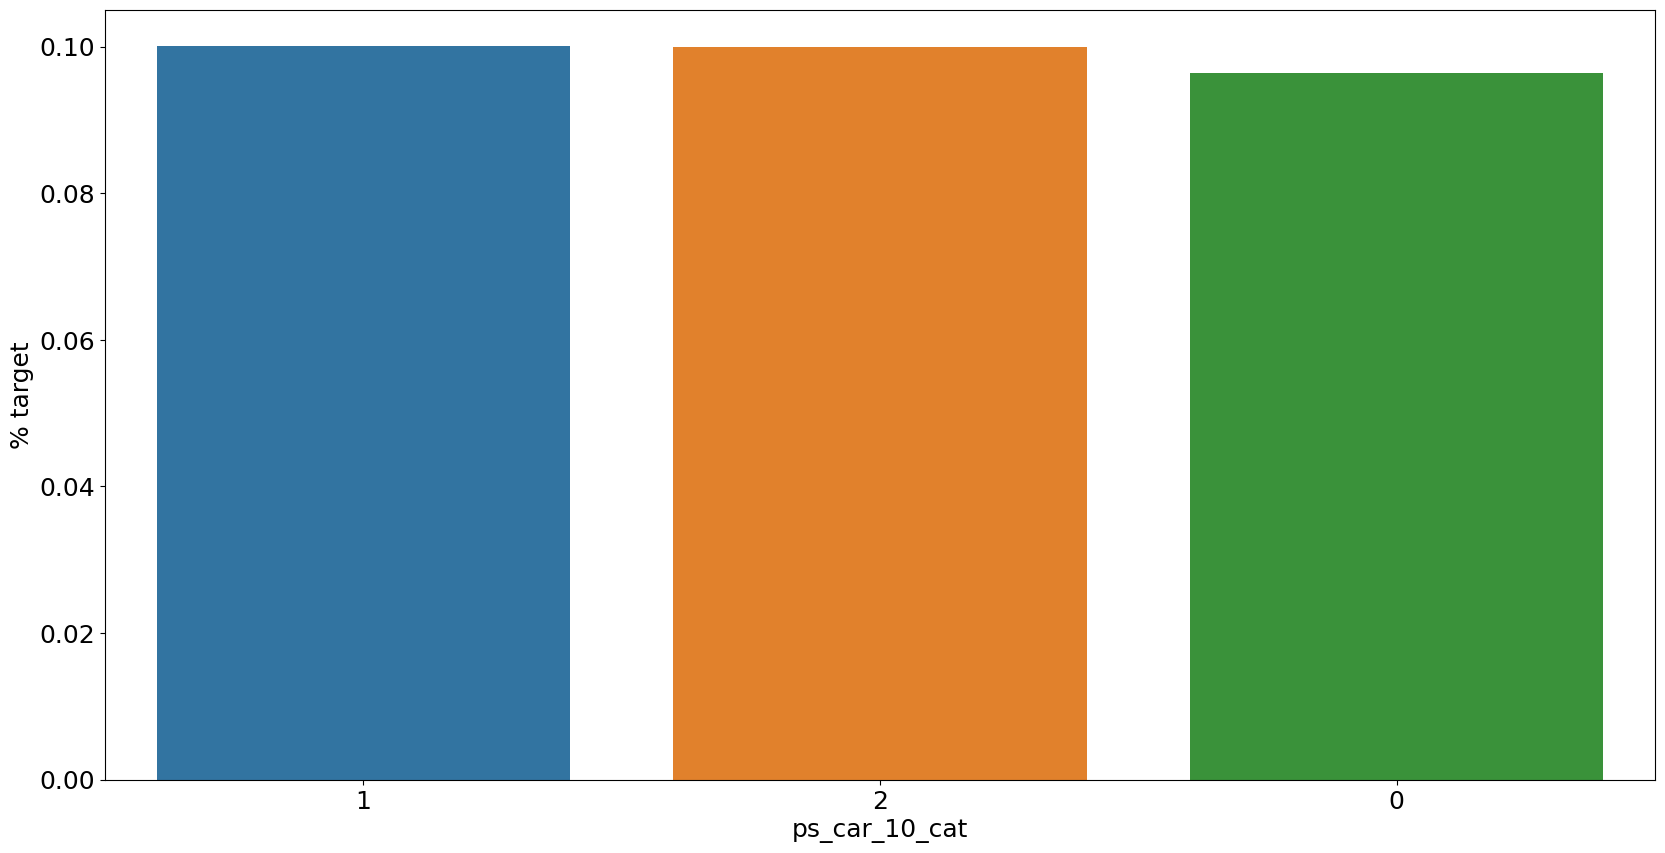

<Figure size 640x480 with 0 Axes>

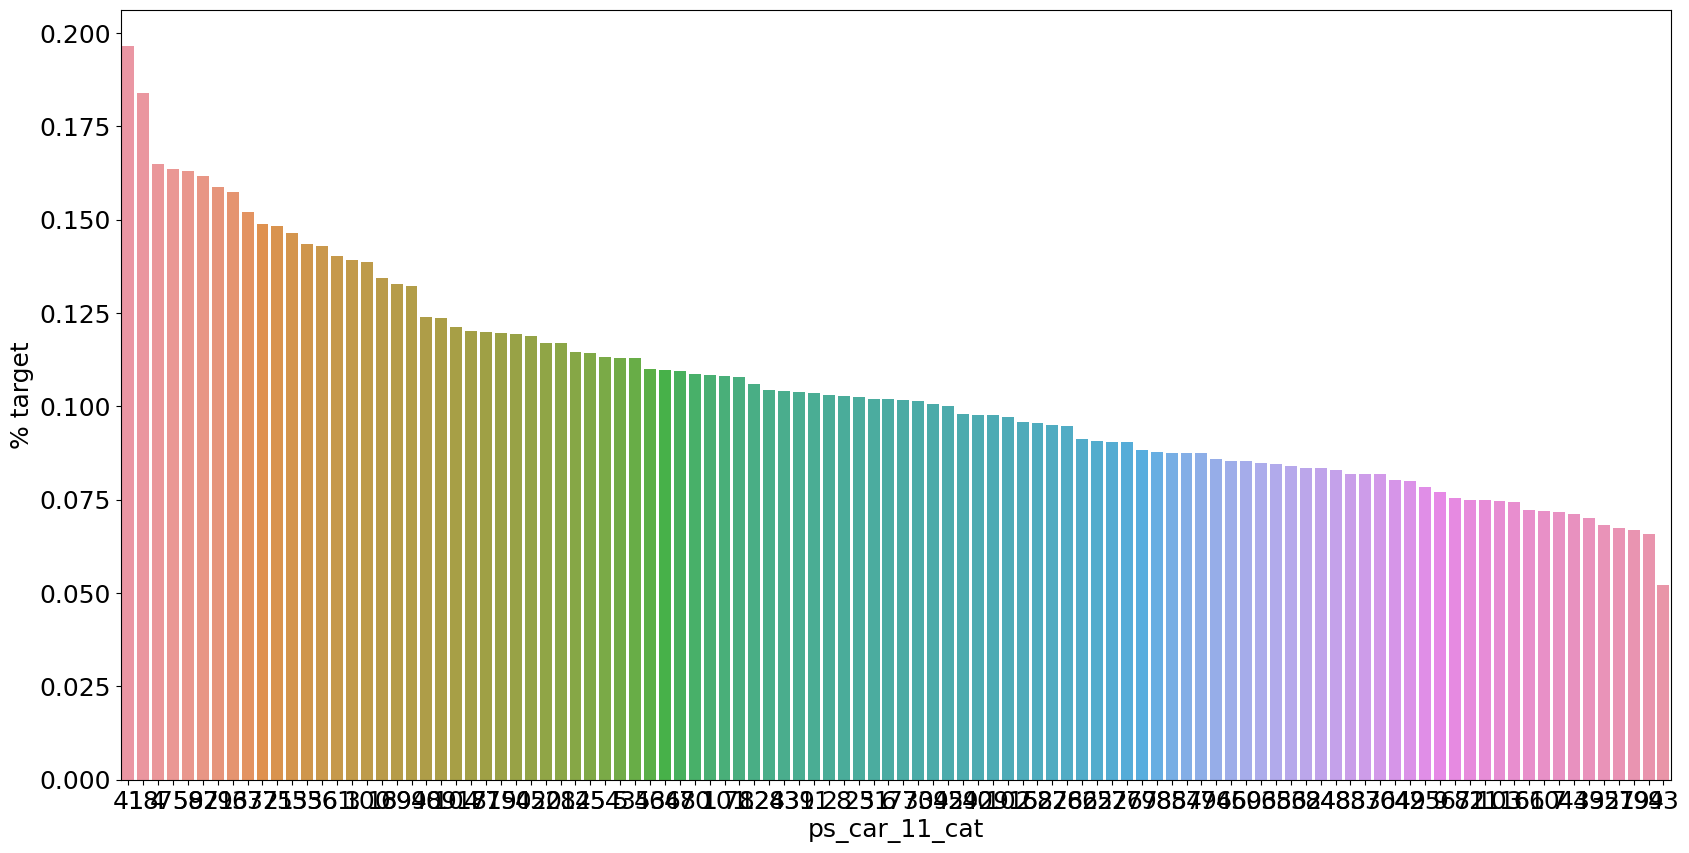

In [39]:
v = meta[(meta.level == "nominal") & (meta.keep)].index
import seaborn as sns
for f in v:
  plt.figure()
  fig, ax = plt.subplots(figsize = (20,10))

  cat_perc = train[[f,"target"]].groupby([f], as_index= False).mean()
  cat_perc.sort_values(by='target', ascending=False, inplace = True)

  sns.barplot(ax = ax, x= f, y= "target", data = cat_perc, order=cat_perc[f])
  plt.ylabel("% target", fontsize = 18)
  plt.xlabel(f, fontsize = 18)
  plt.tick_params(axis="both", which = 'major', labelsize = 18)
  plt.show()

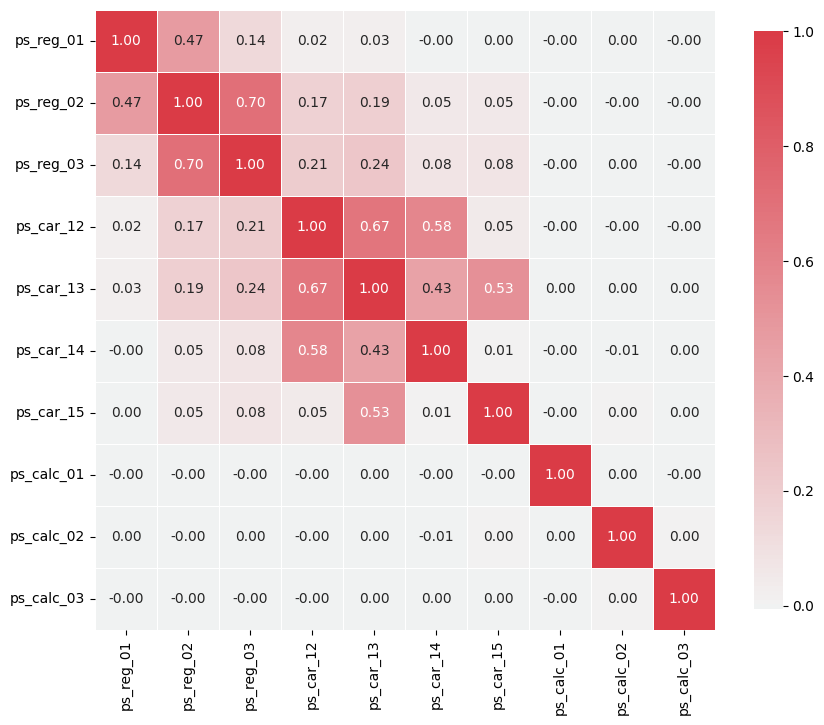

In [42]:
def corr_heatmap(v):
  correlations = train[v].corr()

  cmap = sns.diverging_palette(220, 10, as_cmap = True)
  fig, ax = plt.subplots(figsize = (10,10))
  sns.heatmap(correlations, cmap = cmap, vmax = 1.0, center=0, fmt = '.2f', square = True, linewidth = .5, annot = True,
              cbar_kws = {"shrink" : .75})
  
  plt.show()

v = meta[(meta.level == "interval") & (meta.keep)].index
corr_heatmap(v)

In [43]:
s = train.sample(frac=0.1)

In [ ]:
#scatter_kws: 산점도의 속성을 설정할 수 있는 파라미터

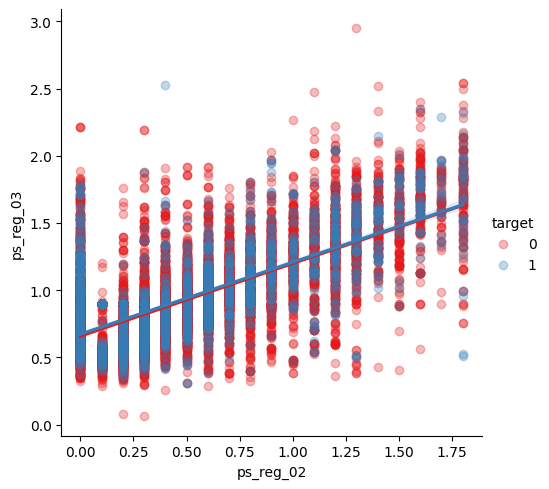

In [44]:
sns.lmplot(x ="ps_reg_02", y = "ps_reg_03", data = s, hue = "target", palette = "Set1", scatter_kws = {"alpha" : 0.3})
plt.show()

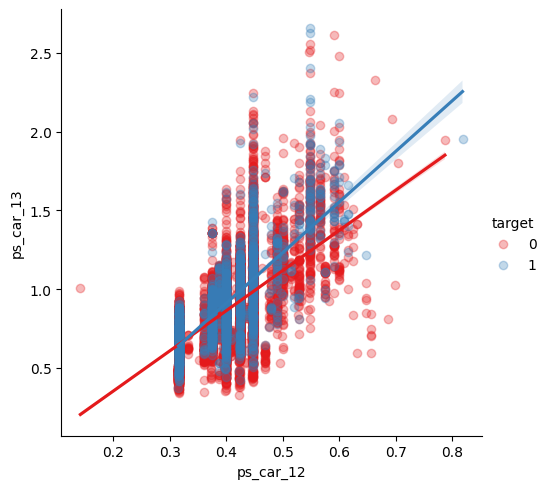

In [46]:
sns.lmplot(x ="ps_car_12", y = "ps_car_13", data = s, hue = "target", palette = "Set1", scatter_kws = {"alpha" : 0.3})
plt.show()

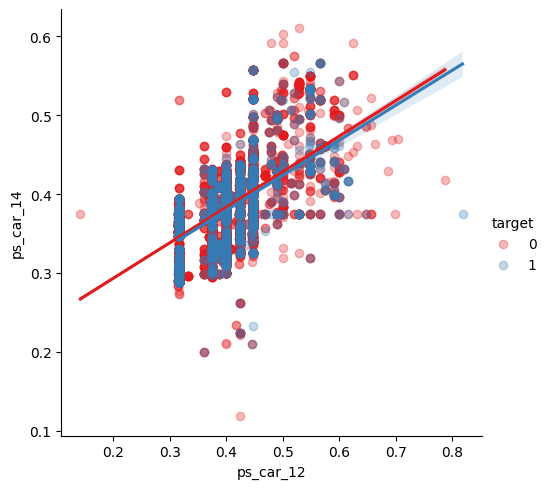

In [47]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

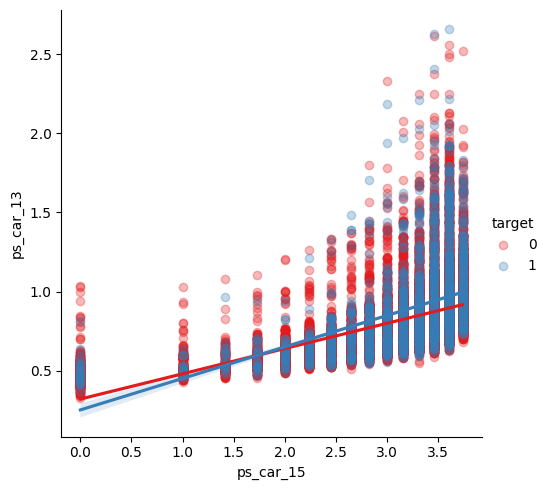

In [48]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

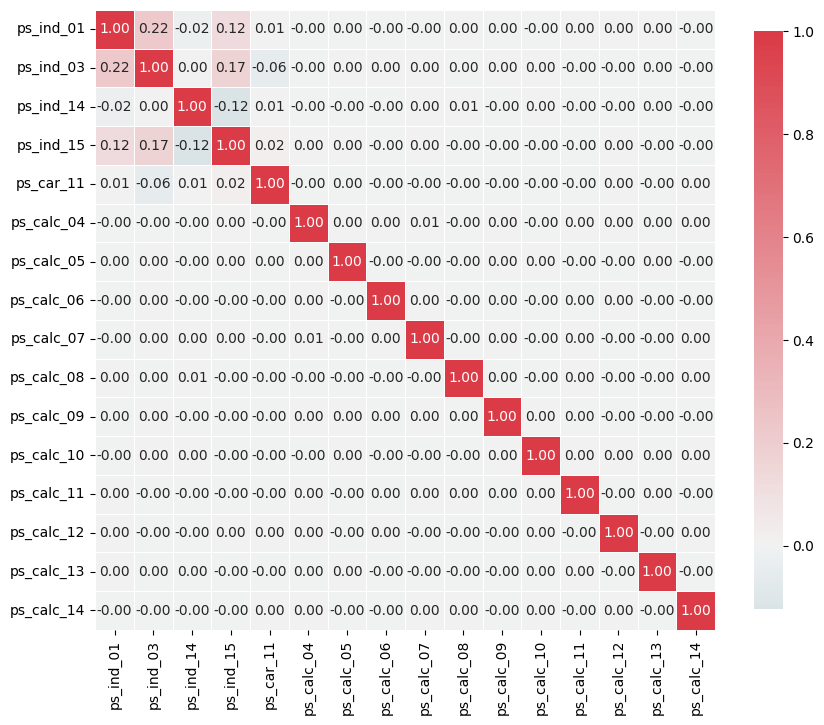

In [50]:
v = meta[(meta.level == "ordinal") & (meta.keep)].index
corr_heatmap(v)

In [52]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
#원 핫 인코딩으로 하는거.
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 211 variables in train


KeyError: ignored

In [58]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names_out(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 266 variables in train
After creating interactions we have 321 variables in train


위 코드는 분산 임계값(Variance Threshold) 방법을 사용하여 변수 선택을 수행하는 코드입니다.

VarianceThreshold는 Scikit-learn의 feature selection 모듈에 있는 클래스로, 분산이 임계값보다 낮은 모든 기능을 제거합니다. 이를 통해 분산이 적은, 즉 값의 변동이 거의 없는 변수를 제거할 수 있습니다.

먼저, VarianceThreshold 객체를 생성하고, fit 메서드를 사용하여 train 데이터에서 id와 target 변수를 제외한 모든 변수에 대한 분산을 계산합니다. get_support() 메서드를 사용하여 각 변수가 기준값 이상의 분산을 가졌는지 여부를 나타내는 불리언 마스크를 생성합니다. 이 때, 불리언 마스크에서 True는 해당 변수의 분산이 임계값 이상이라는 것을 나타내며, False는 해당 변수의 분산이 임계값 미만이라는 것을 나타냅니다.

np.vectorize() 함수를 사용하여 불리언 마스크의 값을 반대로 바꾼 후, columns 속성을 사용하여 기준값 이상의 분산을 가진 변수만을 선택합니다. 이를 통해 분산이 낮은 변수를 제거하고, 분산이 높은 변수만을 선택하여 모델 학습에 사용할 수 있습니다.

In [59]:
selector = VarianceThreshold(threshold = .01)
selector.fit(train.drop(["id", "target"], axis = 1))

f = np.vectorize(lambda x : not x)

v = train.drop(["id", "target"],axis = 1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

105 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_11_cat_2', 'ps_car_11_cat_3', 'ps_car_11_cat_4', 'ps_car_11_cat_6', 'ps_car_11_cat_7', 'ps_car_11_cat_8', 'ps_car_11_cat_9', 'ps_car_11_cat_13', 'ps_car_11_cat_14', 'ps_car_11_cat_15', 'ps_car_11_cat_17', 'ps_car_11_cat_18', 'ps_car_11_cat_19', 'ps_car_11_cat_20', 'ps_car_11_cat_21', 'ps_car_11_cat_23', 'ps_car_11_cat_24', 'ps_car_11_cat_25', 'ps_car_11_cat_26', 'ps_car_11_cat_29', 'ps_car_11_cat_30', 'ps_car_11_cat_31', 'ps_car_11_cat_33', 'ps_car_11_cat_34', 'ps_car_11_cat_35', 'ps_car_11

In [63]:
train.shape[0]

216940

In [64]:
X_train = train.drop(["id", "target"], axis = 1)
y_train = train["target"]

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state = 0, n_jobs = -1)

rf.fit(X_train , y_train)

importances = rf.feature_importances_
indices = np.argsort(rf.feature_importances_)[::-1]


for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_13                      0.010663
 2) ps_car_13^2                    0.010549
 3) ps_reg_03 ps_car_13            0.010518
 4) ps_car_13^2                    0.010482
 5) ps_car_12 ps_car_13            0.010463
 6) ps_reg_03 ps_car_13            0.010460
 7) ps_car_12 ps_car_13            0.010432
 8) ps_car_13 ps_car_14            0.010426
 9) ps_car_13 ps_car_14            0.010370
10) ps_car_13 ps_car_15            0.010263
11) ps_car_13 ps_car_15            0.010249
12) ps_reg_01 ps_car_13            0.010233
13) ps_reg_01 ps_car_13            0.010172
14) ps_reg_03 ps_car_14            0.009758
15) ps_reg_03 ps_car_14            0.009742
16) ps_reg_03 ps_car_12            0.009360
17) ps_reg_03 ps_car_12            0.009343
18) ps_reg_03 ps_car_15            0.009192
19) ps_calc_10                     0.009097
20) ps_reg_03 ps_car_15            0.009031
21) ps_car_14 ps_car_15            0.008990
22) ps_car_14 ps_car_15            0.008964
23) ps_ind_03                   

In [65]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 319


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Number of features after selection: 160


In [1]:
train = train[selected_vars + ["target"]]

scaler = StandardScaler()
scaler.fit_transform(train.drop(["target"], axis = 1))

NameError: ignored